# DSO 560 Project Part I

## Executive Summary

The goal of this projecct to predict tags of different categories for all the clothing products. The categories we chose are `Style`, `Occassion` and `Category`. And the target texts we decided to focus on are `brand`, `product_full_name`, `brand_category`, `details`, and `description`.

How we approached the problem: First of all, we did text cleaning and preprocessing. Then we tried different models (methods) and compared their performances to make sure we're landing on the best model. The codes for all the models we tried will be appended at last. Finally, we chose the best model and compiled everything together to make the model user-friendly.

As a result, LSTM turned out to be the best model and we implemented it on all the categories we chose (Part III Modelling). The LSTM for category reached 96.09% accuracy and 99.48% AUROC (super good). For style and occasion, we did 10-fold cross validation wrapped in 3-time calculation for more accurate accuracy and AUROC. Our final LSTM model for style reached 74.11% - 89.71% accuracy and 79.82% - 94.11% AUROC and the LSTM for occassion reached 71.23% - 86.42% accuracy and 72.69% - 92.31% AUROC.

The output of this project are an Excel worksheet with all the products tagged, a Github repository with all codes and an instruction for prediction in Part IV for further use.

## Contents
### [I. Load Data](#1)
### [II. Text Preprocessing](#2)
### [III. Model Performances](#3)
[Performance 1: LSTM for all styles](#31)
    
[Performance 2: LSTM for all occassions](#32)
   
[Performance 3: LSTM for all categories](#33)

### [IV. Prediction](#4)
[Prediction 1: Style](#41)
    
[Prediction 2: Ocassion](#42)
   
[Prediction 3: Category](#43)

### [V. Appendix](#5)
[1. LSTM Algorithm Exploration & Parameter Tuning](#51)

[2. Neural Net Exploration](#52)

[3. Pre-trained Word Embedding & TF-IDF](#53)

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import nltk
import re
import sklearn
import spacy
import gensim 
import warnings
warnings.simplefilter("ignore")
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from numpy import asarray
from numpy import zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

Using TensorFlow backend.


<a id = '1'></a>

# I. Load Data

In [2]:
conn = psycopg2.connect(database="threadtogether", user="dso_student", password="-H4jgA`rn6w`=Jg(", host="threadtogether.ychennay.com", port="5432")

In [3]:
# View all the tables
cur = conn.cursor()
cur.execute("""select *  
                            from information_schema.tables
                            where table_schema='public'""")
data = cur.fetchall()

In [4]:
pd.DataFrame(data, columns=[desc[0] for desc in cur.description])

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,threadtogether,public,full_data,BASE TABLE,None,None,None,None,None,YES,NO,None
1,threadtogether,public,womens_clothing_reviews,BASE TABLE,None,None,None,None,None,YES,NO,None
2,threadtogether,public,tagged_product_attributes,BASE TABLE,None,None,None,None,None,YES,NO,None
3,threadtogether,public,categories,BASE TABLE,None,None,None,None,None,YES,NO,None
4,threadtogether,public,outfits,BASE TABLE,None,None,None,None,None,YES,NO,None
5,threadtogether,public,outfit_combinations,VIEW,None,None,None,None,None,NO,NO,None


In [5]:
# Extract data from full_data
cur = conn.cursor()
cur.execute("select *  from full_data")
data = cur.fetchall()

In [6]:
full_data = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])
full_data.head()

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id
0,01DSE9TC2DQXDG6GWKW9NMJ416,Banana Republic,514683,Ankle-Strap Pump,"A modern pump, in a rounded silhouette with an...",Unknown,2019-11-11 22:37:15.719107+00,2019-12-19 20:40:30.786144+00,NULL,https://bananarepublic.gap.com/browse/product....,"A modern pump, in a rounded silhouette with an...","{""Needs Review""}",NULL
1,01DSE9SKM19XNA6SJP36JZC065,Banana Republic,526676,Petite Tie-Neck Top,Dress it down with jeans and sneakers or dress...,Unknown,2019-11-11 22:36:50.682513+00,2019-12-19 20:40:30.786144+00,NULL,https://bananarepublic.gap.com/browse/product....,Dress it down with jeans and sneakers or dress...,"{""Needs Review""}",NULL
2,01DSJX8GD4DSAP76SPR85HRCMN,Loewe,4.001E+11,52MM Padded Leather Round Sunglasses,Padded leather covers classic round sunglasses.,JewelryAccessories/SunglassesReaders/RoundOval...,2019-11-13 17:33:59.581661+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/loewe-52mm-pad...,100% UV protection\nCase and cleaning cloth in...,"{""Needs Review""}",NULL
3,01DSJVKJNS6F4KQ1QM6YYK9AW2,Converse,4.00012E+11,Baby's & Little Kid's All-Star Two-Tone Mid-To...,The iconic mid-top design gets an added dose o...,"JustKids/Shoes/Baby024Months/BabyGirl,JustKids...",2019-11-13 17:05:05.203733+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/converse-babys...,Canvas upper\nRound toe\nLace-up vamp\nSmartFO...,"{""Needs Review""}",NULL
4,01DSK15ZD4D5A0QXA8NSD25YXE,Alexander McQueen,4.00011E+11,64MM Rimless Sunglasses,Hexagonal shades offer a rimless view with int...,JewelryAccessories/SunglassesReaders/RoundOval,2019-11-13 18:42:30.941321+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/alexander-mcqu...,100% UV protection\nGradient lenses\nAdjustabl...,"{""Needs Review""}",NULL


In [7]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48979 entries, 0 to 48978
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           48979 non-null  object
 1   brand                48979 non-null  object
 2   mpn                  48979 non-null  object
 3   product_full_name    48979 non-null  object
 4   description          41005 non-null  object
 5   brand_category       48741 non-null  object
 6   created_at           48979 non-null  object
 7   updated_at           48979 non-null  object
 8   deleted_at           45984 non-null  object
 9   brand_canonical_url  48967 non-null  object
 10  details              47950 non-null  object
 11  labels               48979 non-null  object
 12  bc_product_id        48979 non-null  object
dtypes: object(13)
memory usage: 4.9+ MB


In [8]:
# Extract data from tagged_product_attributes
cur = conn.cursor()
cur.execute("select *  from tagged_product_attributes")
data = cur.fetchall()

In [9]:
tagged_data = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])
tagged_data.head()

,product_id,product_color_id,attribute_name,attribute_value,file
0,01DVBTBPHR8WJTCVEN5AJRHF47,01DVBTBPJ41VVT00JJCG8TTZ2W,gender,Women,initial_tags
1,01DVA7QRXM928ZM0WWR7HFNTC1,01DVA7QRXXR9F0TWVE1HMC5ZQ3,Primary Color,Blacks,initial_tags
2,01DPGV4YRP3Z8J85DASGZ1Y99W,01DPGVGBK6YGNYGNF2S6FSH02T,style,Casual,initial_tags
3,01E1JM43NQ3H17PB22EV3074NX,01E1JM5WFWWCCCH3JTTTCYQCEQ,style,Modern,initial_tags
4,01DSE8Z2ZDAZKZ2SKCS1E3B3HK,01DSE8ZG8Y3FR8KWE2TY1QDWBF,shoe_width,Medium,initial_tags


In [10]:
tagged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119345 entries, 0 to 119344
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   product_id        119345 non-null  object
 1   product_color_id  119345 non-null  object
 2   attribute_name    119345 non-null  object
 3   attribute_value   119345 non-null  object
 4   file              119345 non-null  object
dtypes: object(5)
memory usage: 4.6+ MB


In [11]:
# Extract data from womens_clothing_reviews
cur = conn.cursor()
cur.execute("select *  from womens_clothing_reviews")
data = cur.fetchall()

In [12]:
reviews = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])
reviews.head()

,clothing_id,age,title,review_text,rating,recommend,likes,division,department,class
0,767,33,None,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,None,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [13]:
# Extract data from categories
cur = conn.cursor()
cur.execute("select *  from categories")
data = cur.fetchall()

In [14]:
# View
pd.DataFrame(data, columns=[desc[0] for desc in cur.description]).head()

,value,category,type,quantifier
0,Androgynous,style,general,many
1,Athleisure,style,general,many
2,Boho,style,general,many
3,Business Casual,style,general,many
4,Casual,style,general,many


In [15]:
# Extract data from outfits
cur = conn.cursor()
cur.execute("select *  from outfits")
data = cur.fetchall()

In [16]:
# View
pd.DataFrame(data, columns=[desc[0] for desc in cur.description]).head()

,outfit_id,product_color_id,outfit_item_type
0,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2S83FARJW4QWRBXNS,shoe
1,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2V2Y8EN8YPY1E16EV,accessory1
2,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA23E5A8GBES8QJN3HF,top
3,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2C7BQN0X7MNNYXBHW,bottom
4,01DMHCX50CFX5YNG99F3Y65GQW,01DMBRYVA2S83FARJW4QWRBXNS,shoe


In [17]:
outfit = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])

In [18]:
np.unique(outfit['outfit_item_type'])

array(['accessory1', 'accessory2', 'accessory3', 'bottom', 'onepiece',
       'shoe', 'top'], dtype=object)

<a id = '2'></a>

# II. Text Preprocessing

In [19]:
# join full_data and tagged_data. Replace NAs and \n
join_data = full_data.merge(tagged_data, on='product_id')
join_data = join_data.replace(np.nan, "", regex=True)
join_data = join_data.replace("\n", "",regex=True)
join_data['attribute_value'].replace(r'\bbusinesscasual\b', 'business casual', inplace=True, regex=True)
join_data.head(3)

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id,product_color_id,attribute_name,attribute_value,file
0,01E5ZXP5H0BTEZT9QD2HRZJ47A,A.L.C.,5529544,Lennox High Waist Cotton & Linen Pants,High-rise trousers tailored from a cool Italia...,Unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"True to size. High rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,linenblend,additional
1,01E5ZXP5H0BTEZT9QD2HRZJ47A,A.L.C.,5529544,Lennox High Waist Cotton & Linen Pants,High-rise trousers tailored from a cool Italia...,Unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"True to size. High rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,cottonblend,additional
2,01E5ZXP5H0BTEZT9QD2HRZJ47A,A.L.C.,5529544,Lennox High Waist Cotton & Linen Pants,High-rise trousers tailored from a cool Italia...,Unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"True to size. High rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,style,modern,additional


In [20]:
# Lower case some target texts
columns_list = ['brand','product_full_name','description','brand_category','details',
                'attribute_name','attribute_value']
for column in columns_list:
    join_data[column] = join_data[column].str.lower()
join_data.head(3)

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id,product_color_id,attribute_name,attribute_value,file
0,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c.,5529544,lennox high waist cotton & linen pants,high-rise trousers tailored from a cool italia...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"true to size. high rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,linenblend,additional
1,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c.,5529544,lennox high waist cotton & linen pants,high-rise trousers tailored from a cool italia...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"true to size. high rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,cottonblend,additional
2,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c.,5529544,lennox high waist cotton & linen pants,high-rise trousers tailored from a cool italia...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"true to size. high rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,style,modern,additional


In [21]:
# Remove stopwords
from nltk.corpus import stopwords
from nltk import word_tokenize

columns_list2 = ['brand','product_full_name','description','brand_category','details']
nltk_stopwords = set(stopwords.words('english') + [".",",",":","''","'s","'","``","(", ")","]",
                                                   "-","!","/",">","<",";","#","...","..","?","--","[","&"])
for column in columns_list2:
    join_data[column] = join_data[column].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in nltk_stopwords]))
    
join_data.head(3)

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id,product_color_id,attribute_name,attribute_value,file
0,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c,5529544,lennox high waist cotton linen pants,high-rise trousers tailored cool italian cotto...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,true size high rise.31 inseam 14 leg opening 1...,[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,linenblend,additional
1,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c,5529544,lennox high waist cotton linen pants,high-rise trousers tailored cool italian cotto...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,true size high rise.31 inseam 14 leg opening 1...,[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,cottonblend,additional
2,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c,5529544,lennox high waist cotton linen pants,high-rise trousers tailored cool italian cotto...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,true size high rise.31 inseam 14 leg opening 1...,[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,style,modern,additional


In [22]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

for column in columns_list2:
    join_data[column] = join_data[column].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

<a id = '3'></a>

# III. Modelling

In [23]:
# Join all the target texts we need into a new column called 'tag_info'
join_data['tag_info'] = join_data[['brand','product_full_name','brand_category','details','description']].apply(lambda x: ' '.join(x), axis=1)
join_data['tag_info'][0]

'a.l.c lennox high waist cotton linen pant unknown true size high rise.31 inseam 14 leg opening 12 front rise 15 1/2 back rise size 8 zip fly hook-and-bar closurefront slant pocket back welt pockets67 % cotton 33 % linendry cleanimportedvia c high-rise trouser tailored cool italian cotton-and-linen blend make refreshing addition work wardrobe'

<a id = '31'></a>

## Performance 1: LSTM for all styles

Since this part will take about 24 hours to run, we unfortunately did not finishing running this part. But we can still see from some of the results that this would be a very decent model. If we'd have more time, we'd be happy to present all the results.

In [24]:
# Get all the records with 'style' tagged
Style = join_data[join_data['attribute_name']=='style'][['tag_info', 'attribute_value']]
Style.shape

(25539, 2)

In [25]:
# Remove duplicates
Style = join_data[join_data['attribute_name']=='style'][['tag_info', 'attribute_value']].drop_duplicates()
Style.shape

(10971, 2)

In [26]:
# Get all the attribute value for category 'style'
stylelist = list(np.unique(Style['attribute_value']))

In [27]:
# reset index for the dataframe Style
Style.reset_index(drop=True, inplace=True)

In [28]:
# Get dummies for all attribute values
for sty in np.unique(Style['attribute_value']):
    Style[sty] = 0
    Style[sty][Style['attribute_value']==sty]=1
Style.head(10)

,tag_info,attribute_value,androgynous,athleisure,boho,business casual,casual,classic,edgy,glam,modern,retro,romantic
0,a.l.c lennox high waist cotton linen pant unkn...,modern,0,0,0,0,0,0,0,0,1,0,0
1,a.l.c lennox high waist cotton linen pant unkn...,business casual,0,0,0,1,0,0,0,0,0,0,0
2,a.l.c lennox high waist cotton linen pant unkn...,classic,0,0,0,0,0,1,0,0,0,0,0
3,banana republic mock-neck sweater top unknown ...,classic,0,0,0,0,0,1,0,0,0,0,0
4,banana republic mock-neck sweater top unknown ...,business casual,0,0,0,1,0,0,0,0,0,0,0
5,simon miller rost belted short unknown true si...,modern,0,0,0,0,0,0,0,0,1,0,0
6,simon miller rost belted short unknown true si...,casual,0,0,0,0,1,0,0,0,0,0,0
7,simon miller rost belted short unknown true si...,androgynous,1,0,0,0,0,0,0,0,0,0,0
8,a.l.c minelli silk sleeveless top unknown true...,modern,0,0,0,0,0,0,0,0,1,0,0
9,a.l.c minelli silk sleeveless top unknown true...,boho,0,0,1,0,0,0,0,0,0,0,0


In [29]:
# Import tools for tokenizaton and encoding
from keras.preprocessing.text import Tokenizer
from typing import List
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Import Keras Toolkit
from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers.recurrent import  LSTM
from keras.layers import Flatten, Masking

# Define integer encoder for documents
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

# Define max length detection tool
def get_max_token_length_per_doc(docs: List[List[str]])-> int:
    return max(list(map(lambda x: len(x.split()), docs)))

# Load in GloVe Vectors
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


In [30]:
# import K-Fold validation
from sklearn.model_selection import KFold

In [31]:
stylelist

['androgynous',
 'athleisure',
 'boho',
 'business casual',
 'casual',
 'classic',
 'edgy',
 'glam',
 'modern',
 'retro',
 'romantic']

Due to the randomness of neural network, we set 3 loops (limited time & resources) to average all the metrics, and within each loop, 10-fold cross-validation is applied. Therefore, totally 3 * 10 = 30 loops for each style to achieve relatively lower variance.

In [ ]:
warnings.filterwarnings("ignore")
for style in stylelist:
    
    print(style,'=========================================')
    
    acclist = []
    precisionlist = []
    recalllist = []
    auclist = []

    data = Style.groupby('tag_info').agg(specific_style = pd.NamedAgg(column=style, aggfunc='max')).reset_index()
    data1 = data[data['specific_style']==1]
    if round(len(data1)*1.7) <= len(data[data['specific_style']==0]):
        data2 = data[data['specific_style']==0].sample(round(len(data1)*1.7), random_state=123)
        data = pd.concat([data1, data2])

    tag_list = list(data['tag_info'])

    # Tokenize the Text
    tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
    tokenizer.fit_on_texts(tag_list)

    # get the max length in terms of token length
    max_length = get_max_token_length_per_doc(tag_list)

    # integer encode the documents
    encoded_docs = integer_encode_documents(tag_list, tokenizer)
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

    encoder = LabelEncoder()
    labels = data['specific_style']
    labels = to_categorical(encoder.fit_transform(labels))

    X_train = padded_docs
    y_train = labels
    
    VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

    # Load in Embeddings
    # create a weight matrix for words in training docs
    embedding_matrix = zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: # check that it is an actual word that we have embeddings for
            embedding_matrix[i] = embedding_vector

    def make_lstm_classification_model(plot=False):
        model = Sequential()
        model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
        model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
        model.add(LSTM(units=32, input_shape=(1, max_length)))
        # model.add(Dense(16))
        model.add(Dense(8))
        model.add(Dense(2, activation='sigmoid'))

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


        if plot:
            plot_model(model, to_file='model.png', show_shapes=True)
        return model
    
    for loop in range(3):
        
        model = make_lstm_classification_model()
        
        # k-fold cross validation
        kfold = KFold(n_splits=10, shuffle=True)
        # enumerate splits
        for train_index, test_index in kfold.split(X_train):
            # split train & test
            cross_train_X, cross_test_X = X_train[train_index], X_train[test_index]
            cross_train_y, cross_test_y = y_train[train_index], y_train[test_index]
            # fit model
            model = make_lstm_classification_model()
            model.fit(cross_train_X, cross_train_y, epochs=15, verbose=0)
            # evaluate model
            y_prob = model.predict(cross_test_X) 
            y_classes = y_prob.argmax(axis=-1)
            ytest = [np.argmax(y, axis=None, out=None) for y in cross_test_y]
            # acc
            acc = sklearn.metrics.accuracy_score(ytest, y_classes)
            # precision 
            precision = sklearn.metrics.precision_score(ytest, y_classes)
            # recall
            recall = sklearn.metrics.recall_score(ytest, y_classes)
            # auc
            auc = sklearn.metrics.roc_auc_score(ytest, [y[1] for y in y_prob])

            acclist.append(acc)
            precisionlist.append(precision)
            recalllist.append(recall)
            auclist.append(auc)

    print('accuracy: %f' % np.mean(acclist))
    print('precision: %f' % np.mean(precisionlist))
    print('recall: %f' % np.mean(recalllist))
    print('AUROC: %f' % np.mean(auclist))

androgynous =========================================
accuracy: 0.741099
precision: 0.657893
recall: 0.644889
AUROC: 0.798162
athleisure =========================================
accuracy: 0.897072
precision: 0.875992
recall: 0.853442
AUROC: 0.941067
boho =========================================
accuracy: 0.757938
precision: 0.678114
recall: 0.677041
AUROC: 0.799809
business casual =========================================
accuracy: 0.769491
precision: 0.697760
recall: 0.679328
AUROC: 0.826173
casual =========================================
accuracy: 0.799254
precision: 0.854350
recall: 0.845050
AUROC: 0.852494
classic =========================================


<a id = '32'></a>

## Performance 2: LSTM for all occasions

In [32]:
Occasion = join_data[join_data['attribute_name']=='occasion'][['tag_info', 'attribute_value']]
Occasion.shape

(21263, 2)

In [33]:
Occasion = join_data[join_data['attribute_name']=='occasion'][['tag_info', 'attribute_value']].drop_duplicates()
Occasion.shape

(10428, 2)

In [34]:
occasionlist = list(np.unique(Occasion['attribute_value']))

In [35]:
occasionlist

['coldweather',
 'day to night',
 'daytonight',
 'night out',
 'nightout',
 'vacation',
 'weekend',
 'work',
 'workout']

In [36]:
Occasion.loc[Occasion['attribute_value'] ==   'daytonight', 'attribute_value'] =  'day to night'
Occasion.loc[Occasion['attribute_value'] ==   'nightout', 'attribute_value'] =  'night out'

In [37]:
occasionlist = list(np.unique(Occasion['attribute_value']))

In [38]:
Occasion['attribute_value'].value_counts()

day to night    3625
weekend         3083
work            1388
night out       1247
vacation         685
coldweather      242
workout          158
Name: attribute_value, dtype: int64

In [39]:
Occasion.reset_index(drop=True, inplace=True)

In [40]:
# Prepare data
for occ in np.unique(Occasion['attribute_value']):
    Occasion[occ] = 0
    Occasion[occ][Occasion['attribute_value']==occ]=1
Occasion.head(10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,tag_info,attribute_value,coldweather,day to night,night out,vacation,weekend,work,workout
0,a.l.c lennox high waist cotton linen pant unkn...,work,0,0,0,0,0,1,0
1,banana republic mock-neck sweater top unknown ...,day to night,0,1,0,0,0,0,0
2,banana republic mock-neck sweater top unknown ...,work,0,0,0,0,0,1,0
3,banana republic mock-neck sweater top unknown ...,day to night,0,1,0,0,0,0,0
4,simon miller rost belted short unknown true si...,weekend,0,0,0,0,1,0,0
5,simon miller rost belted short unknown true si...,vacation,0,0,0,1,0,0,0
6,a.l.c minelli silk sleeveless top unknown true...,day to night,0,1,0,0,0,0,0
7,a.l.c minelli silk sleeveless top unknown true...,vacation,0,0,0,1,0,0,0
8,simon miller nepa mismatched button rib cardig...,day to night,0,1,0,0,0,0,0
9,simon miller nepa mismatched button rib cardig...,vacation,0,0,0,1,0,0,0


In [30]:
# Import tools for tokenizaton and encoding
from keras.preprocessing.text import Tokenizer
from typing import List
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Import Keras Toolkit
from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers.recurrent import  LSTM
from keras.layers import Flatten, Masking

# Define integer encoder for documents
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

# Define max length detection tool
def get_max_token_length_per_doc(docs: List[List[str]])-> int:
    return max(list(map(lambda x: len(x.split()), docs)))

# Load in GloVe Vectors
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


In [42]:
# import K-Fold validation
from sklearn.model_selection import KFold

In [43]:
occasionlist

['coldweather',
 'day to night',
 'night out',
 'vacation',
 'weekend',
 'work',
 'workout']

In [44]:
warnings.filterwarnings("ignore")
for occasion in occasionlist:
    
    print(occasion,'=========================================')
    
    acclist = []
    precisionlist = []
    recalllist = []
    auclist = []

    data = Occasion.groupby('tag_info').agg(specific_occasion = pd.NamedAgg(column=occasion, aggfunc='max')).reset_index()
    
    # 'day to night' and 'weekend' labels are pretty balanced
    
    if occasion not in ['day to night', 'weekend']:
        data1 = data[data['specific_occasion']==1]
        data2 = data[data['specific_occasion']==0].sample(round(len(data1)*1.7), random_state=123)
    else:
        data1 = data[data['specific_occasion']==1]
        data2 = data[data['specific_occasion']==0]
        
    data = pd.concat([data1, data2])
    tag_list = list(data['tag_info'])

    # Tokenize the Text
    tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
    tokenizer.fit_on_texts(tag_list)

    # get the max length in terms of token length
    max_length = get_max_token_length_per_doc(tag_list)

    # integer encode the documents
    encoded_docs = integer_encode_documents(tag_list, tokenizer)
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

    encoder = LabelEncoder()
    labels = data['specific_occasion']
    labels = to_categorical(encoder.fit_transform(labels))

    X_train = padded_docs
    y_train = labels
    
    VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

    # Load in Embeddings
    # create a weight matrix for words in training docs
    embedding_matrix = zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: # check that it is an actual word that we have embeddings for
            embedding_matrix[i] = embedding_vector

    def make_lstm_classification_model(plot=False):
        model = Sequential()
        model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
        model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
        model.add(LSTM(units=32, input_shape=(1, max_length)))
        # model.add(Dense(16))
        model.add(Dense(8))
        model.add(Dense(2, activation='sigmoid'))

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


        if plot:
            plot_model(model, to_file='model.png', show_shapes=True)
        return model
    
    for loop in range(3):
        
        model = make_lstm_classification_model()
        
        # k-fold cross validation
        kfold = KFold(n_splits=10, shuffle=True)
        # enumerate splits
        for train_index, test_index in kfold.split(X_train):
            # split train & test
            cross_train_X, cross_test_X = X_train[train_index], X_train[test_index]
            cross_train_y, cross_test_y = y_train[train_index], y_train[test_index]
            # fit model
            model = make_lstm_classification_model()
            model.fit(cross_train_X, cross_train_y, epochs=15, verbose=0)
            # evaluate model
            y_prob = model.predict(cross_test_X) 
            y_classes = y_prob.argmax(axis=-1)
            ytest = [np.argmax(y, axis=None, out=None) for y in cross_test_y]
            # acc
            acc = sklearn.metrics.accuracy_score(ytest, y_classes)
            # precision 
            precision = sklearn.metrics.precision_score(ytest, y_classes)
            # recall
            recall = sklearn.metrics.recall_score(ytest, y_classes)
            # auc
            auc = sklearn.metrics.roc_auc_score(ytest, [y[1] for y in y_prob])

            acclist.append(acc)
            precisionlist.append(precision)
            recalllist.append(recall)
            auclist.append(auc)

    print('accuracy: %f' % np.mean(acclist))
    print('precision: %f' % np.mean(precisionlist))
    print('recall: %f' % np.mean(recalllist))
    print('AUROC: %f' % np.mean(auclist))

coldweather =========================================
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

accuracy: 0.796239
precision: 0.737244
recall: 0.710087
AUROC: 0.868899
day to night =========================================
accuracy: 0.764079
precision: 0.820472
recall: 0.859563
AUROC: 0.737120
night out =========================================
accuracy: 0.712258
precision: 0.620940
recall: 0.596413
AUROC: 0.745895
vacation =========================================
accuracy: 0.751951
precision: 0.685487
recall: 0.623311
AUROC: 0.788861
weekend =========================================
accuracy: 0.771812
precision: 0.837139
recall: 0.872775
AUROC: 0.726877
work =========================================
accuracy: 0.765839
precision: 0.686095
recall: 0.683000
AUROC: 0.822514
workout =========================================
accuracy: 0.864175
precision: 0.829932
recall: 0.812000
AUROC: 0.923065


<a id = '33'></a>

## Performance 3: LSTM for all categories

In [24]:
Category = join_data[join_data["attribute_name"] == 'category'][['tag_info', 'attribute_value']].drop_duplicates().reset_index(drop=True)
Category.head()

,tag_info,attribute_value
0,a.l.c lennox high waist cotton linen pant unkn...,bottom
1,banana republic mock-neck sweater top unknown ...,top
2,simon miller rost belted short unknown true si...,bottom
3,a.l.c minelli silk sleeveless top unknown true...,top
4,simon miller nepa mismatched button rib cardig...,sweater


In [25]:
# the data dictionary shows there are six categories in total
cur = conn.cursor()
cur.execute("select *  from categories")
data = cur.fetchall()
category = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])
category[category["category"] == "category" ]

,value,category,type,quantifier
64,Top,category,general,one
65,Bottom,category,general,one
66,One Piece,category,general,one
67,Shoe,category,general,one
68,Handbag,category,general,one
69,Scarf,category,general,one


In [26]:
# but actually there are 11 tags 
set(Category.attribute_value)

{'accessory',
 'blazers, coats & jackets',
 'blazerscoatsjackets',
 'bottom',
 'one piece',
 'onepiece',
 'shoe',
 'sweater',
 'sweatshirt & hoodie',
 'sweatshirthoodie',
 'top'}

In [27]:
# we merged three categories with their synonym and turn 11 categories into 8
Category.loc[Category['attribute_value'] == 'blazerscoatsjackets', 'attribute_value'] =  'blazers, coats & jackets'
Category.loc[Category['attribute_value'] == 'onepiece', 'attribute_value'] = 'one piece'
Category.loc[Category['attribute_value'] == 'sweatshirthoodie', 'attribute_value'] =  'sweatshirt & hoodie'
set(Category.attribute_value)

{'accessory',
 'blazers, coats & jackets',
 'bottom',
 'one piece',
 'shoe',
 'sweater',
 'sweatshirt & hoodie',
 'top'}

In [28]:
# their distribution is as follows:
Category.groupby('attribute_value').agg('count')

,tag_info
attribute_value,
accessory,327
"blazers, coats & jackets",385
bottom,943
one piece,581
shoe,695
sweater,302
sweatshirt & hoodie,141
top,975


In [31]:
# use the same LSTM model, the only difference is multiple classification at the output layer 
stopwords_removed_docs = list(Category['tag_info'])
max_length = get_max_token_length_per_doc(stopwords_removed_docs)

tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(stopwords_removed_docs)

# integer encode the documents
encoded_docs = integer_encode_documents(stopwords_removed_docs, tokenizer)
# this is a list of lists, the numbers represent the index position of that word.
# for instance, 33 means the 33rd word in the vocabulary
# Notice the last document has 4 numbers, since it is a 4 word document: Could have done better.
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

encoder = LabelEncoder()
labels = Category.attribute_value
labels = to_categorical(encoder.fit_transform(labels))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.1, random_state=23)

VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

# create a weight matrix for words in training docs
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

In [40]:
# define the model
def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=32, input_shape=(1, max_length)))
    model.add(Dense(16))
    model.add(Dense(8, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [41]:
# compile the model
model = make_lstm_classification_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 187, 100)          1035300   
_________________________________________________________________
masking_2 (Masking)          (None, 187, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
Total params: 1,052,988
Trainable params: 17,688
Non-trainable params: 1,035,300
_________________________________________________________________


In [42]:
# fit the model
history = model.fit(X_train, y_train,validation_split = 0.1, epochs=20, verbose=1)

Train on 3522 samples, validate on 392 samples
Epoch 1/20
3522/3522 [==============================] - 16s 5ms/step - loss: 1.6841 - accuracy: 0.3927 - val_loss: 1.1568 - val_accuracy: 0.5893
Epoch 2/20
3522/3522 [==============================] - 14s 4ms/step - loss: 1.0059 - accuracy: 0.6505 - val_loss: 0.7795 - val_accuracy: 0.7296
Epoch 3/20
3522/3522 [==============================] - 14s 4ms/step - loss: 0.6985 - accuracy: 0.7521 - val_loss: 0.5809 - val_accuracy: 0.7985
Epoch 4/20
3522/3522 [==============================] - 14s 4ms/step - loss: 0.5071 - accuracy: 0.8271 - val_loss: 0.4016 - val_accuracy: 0.8546
Epoch 5/20
3522/3522 [==============================] - 13s 4ms/step - loss: 0.3762 - accuracy: 0.8768 - val_loss: 0.3216 - val_accuracy: 0.8929
Epoch 6/20
3522/3522 [==============================] - 14s 4ms/step - loss: 0.2645 - accuracy: 0.9242 - val_loss: 0.3376 - val_accuracy: 0.8980
Epoch 7/20
3522/3522 [==============================] - 13s 4ms/step - loss: 0.6246

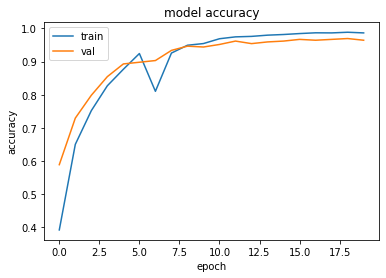

In [43]:
# plot the results
from matplotlib import pyplot as plt

def plot_fit_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_fit_history(history)

In [44]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy: %f' % (accuracy*100))

435/435 [==============================] - 0s 1ms/step
Test Accuracy: 96.091956


In [45]:
# evaluate model
y_prob = model.predict(X_test) 
y_classes = y_prob.argmax(axis=-1)
ytest = [np.argmax(y, axis=None, out=None) for y in y_test]
# acc
acc = sklearn.metrics.accuracy_score(ytest, y_classes)
# auc
auc = sklearn.metrics.roc_auc_score(ytest, y_prob, multi_class='ovo')

print('accuracy: %f' % acc)
print('AUROC: %f' % auc)

accuracy: 0.960920
AUROC: 0.994840


<a id = '4'></a>

# IV. Prediction: get tags for full_data

This part is designed for prediction. There're 2 ways you can use this tool: 
- 1. We've provided a prediction data template (prediction_data_template.xlsx) for you to plug in all the texts you need to change. After doing so, you could use the following 2 lines to load the data in. And then all that's left to do is to run through all the cells in this part.
```
import pandas as pd
full_data = pd.read_excel('prediction_data_template.xlsx')
```

- 2. You can make your own data set with new features as well. For example, you can design your columns as `brand`,`brand_type`,`details`,`descriptions`,`new_details`. In this case, please make sure to name your dataframe as `full_data` after loading it in. Also, if you use your own prediction dataset, please comment out the 3rd line in the next kernel and run the 4th line instead.

Before you run this part, please make sure you've already run part I Load Data and II Text Preprocessing.

In [46]:
full_data = full_data.replace(np.nan, "", regex=True)
full_data = full_data.replace("\n", "",regex=True)
full_data['tag_info'] = full_data[['brand','product_full_name','brand_category','details','description']].apply(lambda x: ' '.join(x), axis=1)
#full_data['tag_info'] = full_data[list(full_data.columns)].apply(lambda x: ' '.join(x), axis=1)
full_data['tag_info'] = full_data['tag_info'].str.lower()

# Remove stopwords
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk_stopwords = set(stopwords.words('english') + [".",",",":","''","'s","'","``","(", ")","]",
                                                   "-","!","/",">","<",";","#","...","..","?","--","[","&"])
full_data['tag_info'] = full_data['tag_info'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in nltk_stopwords]))
# Lemmatization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
full_data['tag_info'] = full_data['tag_info'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))                                             

In [47]:
# Import tools for tokenizaton and encoding
from keras.preprocessing.text import Tokenizer
from typing import List
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences

# Import Keras Toolkit
from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers.recurrent import  LSTM
from keras.layers import Flatten, Masking

# Define integer encoder for documents
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

# Define max length detection tool
def get_max_token_length_per_doc(docs: List[List[str]])-> int:
    return max(list(map(lambda x: len(x.split()), docs)))

# Load in GloVe Vectors
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

embeddings_index = load_glove_vectors()

# import K-Fold validation
from sklearn.model_selection import KFold

Loaded 400000 word vectors.


In [48]:
# Transform full_data['tag_info'] to keras input format
full_input = list(full_data['tag_info'])
tokenizer = Tokenizer(num_words=4000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(full_input)
# Decide the max length of padding size
# Be super careful the padding size of model must be larger (at least equal to) max_length of both training and testing (prediction) set
max_length = get_max_token_length_per_doc(full_input)
full_encoded_docs = integer_encode_documents(full_input, tokenizer)
full_padded_docs = pad_sequences(full_encoded_docs, maxlen=max_length, padding='post')

In [61]:
# full_input2 only take 1500 most frequent words but not 4000, because some of the styles/occasion has too few samples
# Actually only one model use 1500 most frequent words - workout in Ocaasion, which only has around 150 samples, 
# but the performance is still good
full_input2 = list(full_data['tag_info'])
tokenizer2 = Tokenizer(num_words=1500, oov_token="UNKNOWN_TOKEN")
tokenizer2.fit_on_texts(full_input2)
full_encoded_docs2 = integer_encode_documents(full_input2, tokenizer)
full_padded_docs2 = pad_sequences(full_encoded_docs2, maxlen=max_length, padding='post')

In [50]:
# Have a view of max_length
max_length

307

In [51]:
# Here's training set
join_data['tag_info'] = join_data[['brand','product_full_name','brand_category','details','description']].apply(lambda x: ' '.join(x), axis=1)

<a id = '41'></a>

## Prediction 1: Style

In [52]:
# When training model for prediction, should do some format preprocessing to training data set. Here we set the join_data from 
# Part1 & 2 (postgresql database) as our default training dat
Style = join_data[join_data['attribute_name']=='style'][['tag_info', 'attribute_value']].drop_duplicates()
Style.loc[Style['attribute_value'] =='businesscasual', 'attribute_value'] = 'business casual'
stylelist = list(np.unique(Style['attribute_value']))
Style.reset_index(drop=True, inplace=True)
# Prepare data
for sty in np.unique(Style['attribute_value']):
    Style[sty] = 0
    Style[sty][Style['attribute_value']==sty]=1

In [54]:
warnings.filterwarnings("ignore")

# Initialize Style column
full_data['Style'] = '0'
for style in stylelist:
    
    print(style,'=========================================')

    data = Style.groupby('tag_info').agg(specific_style = pd.NamedAgg(column=style, aggfunc='max')).reset_index()
    data1 = data[data['specific_style']==1]
    if round(len(data1)*1.7) <= len(data[data['specific_style']==0]):
        data2 = data[data['specific_style']==0].sample(round(len(data1)*1.7), random_state=123)
        data = pd.concat([data1, data2])
        
    tag_list = list(data['tag_info'])

    # Tokenize the Text
    tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
    tokenizer.fit_on_texts(tag_list)

    # integer encode the documents
    # maxlen here should be large enough to cover both training data and full_data (prediction set)
    encoded_docs = integer_encode_documents(tag_list, tokenizer)
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

    encoder = LabelEncoder()
    labels = data['specific_style']
    labels = to_categorical(encoder.fit_transform(labels))

    X_train = padded_docs
    y_train = labels
    
    VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

    # Load in Embeddings
    # create a weight matrix for words in training docs
    embedding_matrix = zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: # check that it is an actual word that we have embeddings for
            embedding_matrix[i] = embedding_vector

    def make_lstm_classification_model(plot=False):
        model = Sequential()
        model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
        model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
        model.add(LSTM(units=32, input_shape=(1, max_length)))
        # model.add(Dense(16))
        model.add(Dense(8))
        model.add(Dense(2, activation='sigmoid'))

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        if plot:
            plot_model(model, to_file='model.png', show_shapes=True)
        return model
        
    model = make_lstm_classification_model()
    model.fit(X_train, y_train, epochs=15, verbose=1)
    # evaluate model
    y_prob = model.predict(X_train) 
    y_classes = y_prob.argmax(axis=-1)
    ytest = [np.argmax(y, axis=None, out=None) for y in y_train]
    # acc
    acc = sklearn.metrics.accuracy_score(ytest, y_classes)
    # auc
    auc = sklearn.metrics.roc_auc_score(ytest, [y[1] for y in y_prob])

    print('training accuracy: %f' % np.mean(acc))
    print('training AUROC: %f' % np.mean(auc))
    
    y_prob_full = model.predict(full_padded_docs) 
    y_classes_full = y_prob_full.argmax(axis=-1)
    full_data[style] = y_classes_full
    full_data[style][full_data[style]==1] = style
    full_data['Style'] = full_data[['Style', style]].apply(lambda x: ', '.join(x.astype('str')), axis = 1)
    full_data.drop(style, axis=1, inplace=True)
    
full_data['Style'] = full_data['Style'].str.replace(r'0, |, 0', '')
full_data['Style'] = full_data['Style'].str.replace(r'0', '/')

androgynous =========================================
Epoch 1/15
1993/1993 [==============================] - 13s 6ms/step - loss: 0.6508 - accuracy: 0.6267 3s
Epoch 2/15
1993/1993 [==============================] - 12s 6ms/step - loss: 0.6000 - accuracy: 0.6739 
Epoch 3/15
1993/1993 [==============================] - 11s 6ms/step - loss: 0.5385 - accuracy: 0.7371
Epoch 4/15
1993/1993 [==============================] - 11s 5ms/step - loss: 0.5074 - accuracy: 0.7561 2s - l
Epoch 5/15
1993/1993 [==============================] - 11s 6ms/step - loss: 0.4884 - accuracy: 0.7702
Epoch 6/15
1993/1993 [==============================] - 13s 6ms/step - loss: 0.4506 - accuracy: 0.7827
Epoch 7/15
1993/1993 [==============================] - 11s 5ms/step - loss: 0.4322 - accuracy: 0.7973
Epoch 8/15
1993/1993 [==============================] - 11s 5ms/step - loss: 0.3977 - accuracy: 0.8144
Epoch 9/15
1993/1993 [==============================] - 11s 6ms/step - loss: 0.3674 - accuracy: 0.8364
Epoch 10

640/640 [==============================] - 4s 6ms/step - loss: 0.3322 - accuracy: 0.8703
Epoch 11/15
640/640 [==============================] - 4s 6ms/step - loss: 0.2856 - accuracy: 0.8969: 2s - los
Epoch 12/15
640/640 [==============================] - 4s 6ms/step - loss: 0.2320 - accuracy: 0.9297
Epoch 13/15
640/640 [==============================] - 4s 5ms/step - loss: 0.1852 - accuracy: 0.9422
Epoch 14/15
640/640 [==============================] - 3s 5ms/step - loss: 0.1573 - accuracy: 0.9484
Epoch 15/15
640/640 [==============================] - 3s 5ms/step - loss: 0.1472 - accuracy: 0.9594
training accuracy: 0.975000
training AUROC: 0.988556
romantic =========================================
Epoch 1/15
1561/1561 [==============================] - 11s 7ms/step - loss: 0.6503 - accuracy: 0.6316
Epoch 2/15
1561/1561 [==============================] - 9s 6ms/step - loss: 0.5891 - accuracy: 0.6823
Epoch 3/15
1561/1561 [==============================] - 9s 6ms/step - loss: 0.5433 - ac

<a id = '42'></a>

## Prediction 2: Occassion

In [58]:
# When training model for prediction, should do some format preprocessing to training data set. Here we set the join_data from 
# Part1 & 2 (postgresql database) as our default training dat
Occasion = join_data[join_data['attribute_name']=='occasion'][['tag_info', 'attribute_value']].drop_duplicates()
Occasion.loc[Occasion['attribute_value'] ==   'daytonight', 'attribute_value'] =  'day to night'
Occasion.loc[Occasion['attribute_value'] ==   'nightout', 'attribute_value'] =  'night out'
occasionlist = list(np.unique(Occasion['attribute_value']))
Occasion.reset_index(drop=True, inplace=True)
# Prepare data
for occ in np.unique(Occasion['attribute_value']):
    Occasion[occ] = 0
    Occasion[occ][Occasion['attribute_value']==occ]=1

In [64]:
warnings.filterwarnings("ignore")

# Initialize Occasion column
full_data['Occasion'] = '0'
for occasion in occasionlist:
    
    print(occasion,'=========================================')

    data = Occasion.groupby('tag_info').agg(specific_occasion = pd.NamedAgg(column=occasion, aggfunc='max')).reset_index()
    
    # 'day to night' and 'weekend' labels are pretty balanced
    
    if occasion not in ['day to night', 'weekend']:
        data1 = data[data['specific_occasion']==1]
        data2 = data[data['specific_occasion']==0].sample(round(len(data1)*1.7), random_state=123)
    else:
        data1 = data[data['specific_occasion']==1]
        data2 = data[data['specific_occasion']==0]
        
    data = pd.concat([data1, data2])
    tag_list = list(data['tag_info'])

    # Tokenize the Text
    
    if occasion == 'workout':
        tokenizer = Tokenizer(num_words=1500, oov_token="UNKNOWN_TOKEN")
    else:
        tokenizer = Tokenizer(num_words=4000, oov_token="UNKNOWN_TOKEN")
    tokenizer.fit_on_texts(tag_list)

    # integer encode the documents
    # maxlen here should be large enough to cover both training data and full_data (prediction set)
    encoded_docs = integer_encode_documents(tag_list, tokenizer)
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

    encoder = LabelEncoder()
    labels = data['specific_occasion']
    labels = to_categorical(encoder.fit_transform(labels))
    
    X_train = padded_docs
    y_train = labels
    
    VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

    # Load in Embeddings
    # create a weight matrix for words in training docs
    embedding_matrix = zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: # check that it is an actual word that we have embeddings for
            embedding_matrix[i] = embedding_vector

    def make_lstm_classification_model(plot=False):
        model = Sequential()
        model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
        model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
        model.add(LSTM(units=32, input_shape=(1, max_length)))
        # model.add(Dense(16))
        model.add(Dense(8))
        model.add(Dense(2, activation='sigmoid'))

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        if plot:
            plot_model(model, to_file='model.png', show_shapes=True)
        return model
        
    model = make_lstm_classification_model()
    model.fit(X_train, y_train, epochs=15, verbose=1)
    # evaluate model
    y_prob = model.predict(X_train) 
    y_classes = y_prob.argmax(axis=-1)
    ytest = [np.argmax(y, axis=None, out=None) for y in y_train]
    # acc
    acc = sklearn.metrics.accuracy_score(ytest, y_classes)
    # auc
    auc = sklearn.metrics.roc_auc_score(ytest, [y[1] for y in y_prob])

    print('training accuracy: %f' % np.mean(acc))
    print('training AUROC: %f' % np.mean(auc))
    
    if occasion == 'workout':
        y_prob_full = model.predict(full_padded_docs2) 
    else:
        y_prob_full = model.predict(full_padded_docs) 
    y_classes_full = y_prob_full.argmax(axis=-1)
    full_data[occasion] = y_classes_full
    full_data[occasion][full_data[occasion]==1] = occasion
    full_data['Occasion'] = full_data[['Occasion', occasion]].apply(lambda x: ', '.join(x.astype('str')), axis = 1)
    full_data.drop(occasion, axis=1, inplace=True)
    
full_data['Occasion'] = full_data['Occasion'].str.replace(r'0, |, 0', '')
full_data['Occasion'] = full_data['Occasion'].str.replace(r'0', '/')

coldweather =========================================
Epoch 1/15
653/653 [==============================] - 6s 9ms/step - loss: 0.6519 - accuracy: 0.6187
Epoch 2/15
653/653 [==============================] - 5s 7ms/step - loss: 0.5955 - accuracy: 0.7167
Epoch 3/15
653/653 [==============================] - 4s 6ms/step - loss: 0.5116 - accuracy: 0.7565
Epoch 4/15
653/653 [==============================] - 4s 6ms/step - loss: 0.4401 - accuracy: 0.7994
Epoch 5/15
653/653 [==============================] - 4s 7ms/step - loss: 0.4043 - accuracy: 0.8147
Epoch 6/15
653/653 [==============================] - 4s 6ms/step - loss: 0.3688 - accuracy: 0.8438
Epoch 7/15
653/653 [==============================] - 4s 6ms/step - loss: 0.3282 - accuracy: 0.8591
Epoch 8/15
653/653 [==============================] - 4s 7ms/step - loss: 0.3052 - accuracy: 0.8668
Epoch 9/15
653/653 [==============================] - 4s 7ms/step - loss: 0.2873 - accuracy: 0.8806
Epoch 10/15
653/653 [=========================

<a id = '43'></a>

## Prediction 3: Category

In [79]:
# When training model for prediction, should do some format preprocessing to training data set. Here we set the join_data from 
# Part1 & 2 (postgresql database) as our default training dat
Category = join_data[join_data['attribute_name']=='category'][['tag_info', 'attribute_value']].drop_duplicates()
Category.loc[Category['attribute_value'] ==   'blazerscoatsjackets', 'attribute_value'] =  'blazers, coats & jackets'
Category.loc[Category['attribute_value'] ==   'onepiece', 'attribute_value'] = 'one piece'
Category.loc[Category['attribute_value'] ==   'sweatshirthoodie', 'attribute_value'] =  'sweatshirt & hoodie'
Category.reset_index(drop=True, inplace=True)

In [80]:
warnings.filterwarnings("ignore")

# Initialize Category column

data = Category.groupby('tag_info').agg(specific_category = pd.NamedAgg(column='attribute_value', aggfunc='first')).reset_index()
tag_list = list(data['tag_info'])

# Tokenize the Text
tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(tag_list)

# integer encode the documents
# maxlen here should be large enough to cover both training data and full_data (prediction set)
encoded_docs = integer_encode_documents(tag_list, tokenizer)
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

encoder = LabelEncoder()
labels = data['specific_category']
labels = to_categorical(encoder.fit_transform(labels))

X_train = padded_docs
y_train = labels

VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

# Load in Embeddings
# create a weight matrix for words in training docs
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

# define the model
def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=32, input_shape=(1, max_length)))
    model.add(Dense(16))
    model.add(Dense(8, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

model = make_lstm_classification_model()
model.fit(X_train, y_train, epochs=20, verbose=1)

# evaluate model
y_prob = model.predict(X_train) 
y_classes = y_prob.argmax(axis=-1)
ytest = [np.argmax(y, axis=None, out=None) for y in y_train]
# acc
acc = sklearn.metrics.accuracy_score(ytest, y_classes)
# auc
auc = sklearn.metrics.roc_auc_score(ytest, y_prob, multi_class='ovo')

print('training accuracy: %f' % np.mean(acc))
print('training AUROC: %f' % np.mean(auc))

y_prob_full = model.predict(full_padded_docs) 
y_classes_full = y_prob_full.argmax(axis=-1)
y_classes_full = encoder.inverse_transform(y_classes_full)

full_data['Category'] = y_classes_full

Epoch 1/20
4103/4103 [==============================] - 30s 7ms/step - loss: 1.5514 - accuracy: 0.4346
Epoch 2/20
4103/4103 [==============================] - 25s 6ms/step - loss: 0.8952 - accuracy: 0.6815
Epoch 3/20
4103/4103 [==============================] - 25s 6ms/step - loss: 0.6136 - accuracy: 0.8036
Epoch 4/20
4103/4103 [==============================] - 26s 6ms/step - loss: 0.3882 - accuracy: 0.8801
Epoch 5/20
4103/4103 [==============================] - 25s 6ms/step - loss: 0.3644 - accuracy: 0.8913
Epoch 6/20
4103/4103 [==============================] - 25s 6ms/step - loss: 0.2149 - accuracy: 0.9427
Epoch 7/20
4103/4103 [==============================] - 26s 6ms/step - loss: 0.2056 - accuracy: 0.9420
Epoch 8/20
4103/4103 [==============================] - 25s 6ms/step - loss: 0.1594 - accuracy: 0.9586
Epoch 9/20
4103/4103 [==============================] - 25s 6ms/step - loss: 0.1254 - accuracy: 0.9683
Epoch 10/20
4103/4103 [==============================] - 25s 6ms/step - l

Have a view of final labelled full_data set

In [83]:
full_data.drop('tag_info', axis=1, inplace=True)

In [88]:
full_data.head(5)

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id,Style,Occasion,Category
0,01DSE9TC2DQXDG6GWKW9NMJ416,Banana Republic,514683,Ankle-Strap Pump,"A modern pump, in a rounded silhouette with an...",Unknown,2019-11-11 22:37:15.719107+00,2019-12-19 20:40:30.786144+00,NULL,https://bananarepublic.gap.com/browse/product....,"A modern pump, in a rounded silhouette with an...","{""Needs Review""}",NULL,"androgynous, athleisure, casual, classic, modern","day to night, work",top
1,01DSE9SKM19XNA6SJP36JZC065,Banana Republic,526676,Petite Tie-Neck Top,Dress it down with jeans and sneakers or dress...,Unknown,2019-11-11 22:36:50.682513+00,2019-12-19 20:40:30.786144+00,NULL,https://bananarepublic.gap.com/browse/product....,Dress it down with jeans and sneakers or dress...,"{""Needs Review""}",NULL,"androgynous, athleisure, boho, casual, modern,...","day to night, weekend, work",bottom
2,01DSJX8GD4DSAP76SPR85HRCMN,Loewe,4.001E+11,52MM Padded Leather Round Sunglasses,Padded leather covers classic round sunglasses.,JewelryAccessories/SunglassesReaders/RoundOval...,2019-11-13 17:33:59.581661+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/loewe-52mm-pad...,100% UV protectionCase and cleaning cloth incl...,"{""Needs Review""}",NULL,"casual, edgy, glam, modern, retro",weekend,sweater
3,01DSJVKJNS6F4KQ1QM6YYK9AW2,Converse,4.00012E+11,Baby's & Little Kid's All-Star Two-Tone Mid-To...,The iconic mid-top design gets an added dose o...,"JustKids/Shoes/Baby024Months/BabyGirl,JustKids...",2019-11-13 17:05:05.203733+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/converse-babys...,Canvas upperRound toeLace-up vampSmartFOAM ins...,"{""Needs Review""}",NULL,"androgynous, boho, business casual, casual, cl...","day to night, weekend, workout",one piece
4,01DSK15ZD4D5A0QXA8NSD25YXE,Alexander McQueen,4.00011E+11,64MM Rimless Sunglasses,Hexagonal shades offer a rimless view with int...,JewelryAccessories/SunglassesReaders/RoundOval,2019-11-13 18:42:30.941321+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/alexander-mcqu...,100% UV protectionGradient lensesAdjustable no...,"{""Needs Review""}",NULL,"athleisure, boho, casual, classic, edgy, retro",day to night,bottom


In [89]:
full_data.tail(5)

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id,Style,Occasion,Category
48974,01DSNVXY8EJ9FQAJ3MPDMPASHD,Bonpoint,4.00091E+11,Baby's Hooded Jacket,,JustKids/Baby024months/InfantGirls/Outerwear,2019-11-14 21:08:28.040417+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/bonpoint-babys...,Cozy double breasted jacket crafted from cotto...,"{""Needs Review""}",NULL,"boho, casual, retro","day to night, vacation, weekend","blazers, coats & jackets"
48975,01DSGYHA3RMCHENBJVQPBGXM97,Laura Mercier,4.00096E+11,Flawless Fusion Ultra-Longwear Foundation,"WHAT IT ISA 15-hour long wearing, water resist...",SaksBeautyPlace/ForHer/Color/Foundation/Liquid...,2019-11-12 23:17:47.761072+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/laura-mercier-...,"WHAT IT ISA 15-hour long wearing, water resist...","{""Needs Review""}",NULL,"androgynous, athleisure, casual, modern, romantic","day to night, night out, weekend",bottom
48976,01DSJT8H12CAFQQH07SQSQWJ8C,Splendid,4.001E+11,Baby Girl's 2-Piece Ruffle Sweatshirt & Stripe...,Ruffled-trim sweatshirt lends romance to this ...,"JustKids/Baby024months/InfantGirls/Tops,JustKi...",2019-11-13 16:41:34.491443+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/splendid-baby-...,"CrewneckLong sleevesRib-knit neck, cuffs and h...","{""Needs Review""}",NULL,"boho, classic, edgy, modern","day to night, weekend, work, workout",sweater
48977,01DSH2PF9J7QZ44D842B3GMCFN,Florence Eiseman,4.00012E+11,Little Girl's Plaid & Velvet Dress,Pretty plaid dress with velvet collar and velv...,"JustKids/Girls214/ToddlerGirls24/Dresses,JustK...",2019-11-13 00:30:31.212215+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/florence-eisem...,Peter Pan collarShort sleevesBack zipperTwo fr...,"{""Needs Review""}",NULL,"androgynous, boho, classic, modern, retro","day to night, weekend",bottom
48978,01DSH54D3PWHKFZK5A8A2JE3RQ,Gucci,4.00011E+11,Baby Girl's Short-Sleeve Dress,,JustKids/Baby024months/InfantGirls/Dresses,2019-11-13 01:13:04.880787+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/gucci-baby-gir...,Corduroy dress with bowCotton corduroyWeb gros...,"{""Needs Review""}",NULL,modern,weekend,sweatshirt & hoodie


In [91]:
full_data.to_csv('DSO 560 Project Part I - Final Results.csv', index=False)

<a id = '5'></a>

# V. Appendix

This part will include all the other models we tried in order to get a best one. For all the models here, we're taking `androgynous` in style as an example.

<a id = '51'></a>

## 1. LSTM Algorithm Exploration & Parameter Tuning 

### Some of the parameter tuning, due to limit of time & resource, we could only do very small part of the whole project's algorithms. To keep the whole notebook neat and clean, we only show some of the results here:

**Different number of nodes on dense layer, choose number of nodes = 8:**<br>
nolayer =========================<br>
acc: 0.738919<br>
precision: 0.657784<br>
recall: 0.726027<br>
auc: 0.793065<br>
4 =========================<br>
acc: 0.740541<br>
precision: 0.689683<br>
recall: 0.626027<br>
auc: 0.794998<br>
6 =========================<br>
acc: 0.735135<br>
precision: 0.665959<br>
recall: 0.682192<br>
auc: 0.793408<br>
8 =========================<br>
acc: 0.744054<br>
precision: 0.682210<br>
recall: 0.673973<br>
auc: 0.801046<br>
12 =========================<br>
acc: 0.739730<br>
precision: 0.681197<br>
recall: 0.651370<br>
auc: 0.791249<br>
20 =========================<br>
acc: 0.740360<br>
precision: 0.678781<br>
recall: 0.661187<br>
auc: 0.790431<br>
28 =========================<br>
acc: 0.739730<br>
precision: 0.675626<br>
recall: 0.665753<br>
auc: 0.787420<br>
36 =========================<br>
acc: 0.737297<br>
precision: 0.673547<br>
recall: 0.657808<br>
auc: 0.785856<br>

**To deal with imbalanced data set, we tried to subset different size of data set labeled as 0 (for the number of samples labeled as 1 is always much smaller), the numbers here mean X times of the samples with label 1:**<br>
1.0 =========================<br>
acc: 0.706081<br>
precision: 0.616230<br>
recall: 0.772131<br>
auc: 0.774053<br>
1.1 =========================<br>
acc: 0.716266<br>
precision: 0.611659<br>
recall: 0.775721<br>
auc: 0.777126<br>
1.2 =========================<br>
acc: 0.717388<br>
precision: 0.632041<br>
recall: 0.773592<br>
auc: 0.781342<br>
1.3 =========================<br>
acc: 0.722453<br>
precision: 0.660609<br>
recall: 0.742694<br>
auc: 0.796705<br>
1.4 =========================<br>
acc: 0.726277<br>
precision: 0.670427<br>
recall: 0.716408<br>
auc: 0.800644<br>
1.5 =========================<br>
acc: 0.727213<br>
precision: 0.668327<br>
recall: 0.711847<br>
auc: 0.801173<br>
1.6 =========================<br>
acc: 0.728310<br>
precision: 0.669492<br>
recall: 0.702072<br>
auc: 0.801407<br>
1.7 =========================<br>
acc: 0.730022<br>
precision: 0.670665<br>
recall: 0.691813<br>
auc: 0.802030<br>
1.8 =========================<br>
acc: 0.732322<br>
precision: 0.677012<br>
recall: 0.679112<br>
auc: 0.801379<br>
1.9 =========================<br>
acc: 0.734183<br>
precision: 0.676259<br>
recall: 0.672239<br>
auc: 0.800903<br>
2.0 =========================<br>
acc: 0.736645<br>
precision: 0.673135<br>
recall: 0.673309<br>
auc: 0.801277<br>

<a id = '52'></a>

## 2. Neural Net Exploration

In [25]:
style_df = join_data[join_data['attribute_name']=='style'][['attribute_value','tag_info']].drop_duplicates()
print(style_df.shape)
style_df.head(3)

(10971, 2)


,attribute_value,tag_info
2,modern,a.l.c lennox high waist cotton linen pant high...
3,business casual,a.l.c lennox high waist cotton linen pant high...
4,classic,a.l.c lennox high waist cotton linen pant high...


In [26]:
# Create the labels
label_df = pd.get_dummies(style_df['attribute_value'], prefix='label')
model_df = pd.concat([style_df, label_df], axis=1, sort=False)
model_df.head(3)

,attribute_value,tag_info,label_androgynous,label_athleisure,label_boho,label_business casual,label_casual,label_classic,label_edgy,label_glam,label_modern,label_retro,label_romantic
2,modern,a.l.c lennox high waist cotton linen pant high...,0,0,0,0,0,0,0,0,1,0,0
3,business casual,a.l.c lennox high waist cotton linen pant high...,0,0,0,1,0,0,0,0,0,0,0
4,classic,a.l.c lennox high waist cotton linen pant high...,0,0,0,0,0,1,0,0,0,0,0


In [46]:
label_1 = model_df[model_df['label_androgynous']==1][['tag_info','label_androgynous']]

In [48]:
label_0 = model_df[model_df['label_androgynous']==0][['tag_info','label_androgynous']].drop_duplicates().sample(model_df['label_androgynous'].sum())

In [49]:
andro = label_1.append(label_0)
andro

,tag_info,label_androgynous
149,simon miller rost belted short cinched natural...,1
593,tibi juan embossed mule tibi juan embossed mul...,1
772,khaite leather ankle boot heel measure approxi...,1
846,lauren manoogian alpaca-blend scarf brown alpa...,1
1166,carolina herrera pleated stretch-denim wide-le...,1
...,...,...
133887,anine bing charlie boot classic rocker boot bo...,0
143794,tory burch kira chevron quilted leather clutch...,0
152855,mansur gavriel cloud lambskin clutch supple la...,0
150636,sam edelman odila sandal scalloped strap toe d...,0


In [52]:
docs = andro.tag_info
labels = andro.label_androgynous

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(docs, labels, test_size=0.1, random_state=23)

In [54]:
def get_max_token_length_per_doc(docs):
    return max(list(map(lambda x: len(x.split()), docs)))
max_length = get_max_token_length_per_doc(docs)
max_length

169

In [55]:
# Integer Encode the Documents
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(X_train)
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)
encoded_docs = integer_encode_documents(X_train, tokenizer)
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [56]:
vocab_size = int(len(tokenizer.word_index) * 1.3)
print(f"Vocab size is {vocab_size} unique tokens.")

Vocab size is 7178 unique tokens.


In [57]:
EMBEDDING_SIZE = 100
from keras.utils.vis_utils import plot_model

In [58]:
# Define and Compile the Model
# define the model
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=max_length))
model.add(Flatten()) 
# for each document, the output of the embedding layer is 4 x 8 matrix
# (4 since 4 words per document, 8 since size 8 embedding). Flatten makes this a 32 x 1 vector.
model.add(Dense(1, activation='sigmoid')) 
# these 32 elements are coalesced into one final output node, a sigmoid
# that outputs a probability of positive or negative
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 169, 100)          717800    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16900)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16901     
Total params: 734,701
Trainable params: 734,701
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
# fit the model
model.fit(padded_docs, y_train, epochs=50,verbose=1)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, y_train, verbose=1)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/50
1328/1328 [==============================] - 1s 667us/step - loss: 0.6970 - acc: 0.5060
Epoch 2/50
1328/1328 [==============================] - 0s 365us/step - loss: 0.6046 - acc: 0.7696
Epoch 3/50
1328/1328 [==============================] - 0s 363us/step - loss: 0.4787 - acc: 0.8230
Epoch 4/50
1328/1328 [==============================] - 0s 375us/step - loss: 0.3626 - acc: 0.8660
Epoch 5/50
1328/1328 [==============================] - 0s 363us/step - loss: 0.2791 - acc: 0.8795
Epoch 6/50
1328/1328 [==============================] - 1s 409us/step - loss: 0.2307 - acc: 0.8870
Epoch 7/50
1328/1328 [==============================] - 0s 376us/step - loss: 0.2053 - acc: 0.8810
Epoch 8/50
1328/1328 [==============================] - 1s 386us/step - loss: 0.1910 - acc: 0.8878
Epoch 9/50
1328/1328 [==============================] - 0s 367us/step - loss: 0.1816 - acc: 0.8870
Epoch 10/50
1328/1328 [==============================] - 0s 367us/step - loss: 0.1757 - acc: 0.8901
Epoch 11/

In [62]:
# Test model
encoded_test_docs = integer_encode_documents(X_test, tokenizer)
padded_test_docs = pad_sequences(encoded_test_docs, maxlen=max_length, padding='post')
prediction = model.predict_classes(padded_test_docs, verbose=0) # there's also presict_classes
loss, accuracy = model.evaluate(padded_test_docs, y_test, verbose=0)
print('Test Accuracy: %f' % (accuracy*100))

Test Accuracy: 64.864865


In [66]:
# Get recall and precision
from sklearn.metrics import recall_score, precision_score
recall = recall_score(y_test, prediction)
precision = precision_score(y_test, prediction)
print(round(recall*100,2),round(precision*100,2))

72.13 55.7


<a id = '53'></a>

## 3. Pre-trained Word Embedding & TF-IDF 

In [30]:
Style = join_data[join_data['attribute_name']=='style'][['tag_info', 'attribute_value']].drop_duplicates()

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Style['tag_info'], Style['attribute_value'], test_size=0.1, random_state=23)

In [73]:
import pandas as pd
import spacy

# load spacy en_core_web_md model
nlp = spacy.load("en_core_web_md")

In [74]:
for idx, info in enumerate(X_train):
    print(nlp(info))
    print(nlp(info).vector[:10]) 
    
    if idx == 3: # stop printing after first 5 or so, takes a long time!
        break

stuart weitzman nearlynude suede sandal heel measure approximately 65mm/ 2.5 inch black suede buckle-fastening ankle strap made spain shoe sandal mid heel fit true size take normal size italian sizing
[-0.04354022  0.22852366 -0.08482351 -0.03297778  0.21501721 -0.08279714
 -0.09283376  0.04464567  0.02363911  0.7117972 ]
cotton citizen sydney crewneck tee la-based label latest crop elevated staple slouchy tee get luxuriously soft feel blend supima® cotton micromodal unknown true size xs=0-2 s=4-6 m=8-10 l=12-14.27 1/2 length size medium crewneckelbow-length sleeves50 % supima cotton 50 % micromodalmachine wash tumble drymade usavia c
[-0.07908691  0.28327072 -0.0611436  -0.05602018  0.03003889 -0.00633907
  0.02156887 -0.02853958 -0.06940804  0.7416781 ]
allsaints keri cyla shirt airy split-collar blouse detailed delicate bloom easy day-to-night charm unknown true size xs=00-0 s=2-4 m=6-8 l=10.26 1/2 length size medium split neck spread collarlong sleeves100 % viscosehand wash line dr

In [75]:
all_data = pd.concat([Style['tag_info'], pd.Series(stylelist)], ignore_index=True)

In [76]:
all_data.tail(20)

10962    atm anthony thomas melillo brushed twill crop ...
10963    atm anthony thomas melillo slim crop pant tail...
10964    atm anthony thomas melillo slim crop pant tail...
10965    atm anthony thomas melillo slim crop pant tail...
10966    atm anthony thomas melillo camo print silk ski...
10967    atm anthony thomas melillo camo print silk ski...
10968    atm anthony thomas melillo camo print silk ski...
10969    atm anthony thomas melillo stretch pima cotton...
10970    atm anthony thomas melillo stretch pima cotton...
10971                                          androgynous
10972                                      athlete leisure
10973                                                 boho
10974                                      business casual
10975                                               casual
10976                                              classic
10977                                                 edgy
10978                                                 gl

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(all_data)

tf_idf_lookup_table = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [78]:
DOCUMENT_SUM_COLUMN = "DOCUMENT_TF_IDF_SUM"

# sum the tf idf scores for each document
tf_idf_lookup_table[DOCUMENT_SUM_COLUMN] = tf_idf_lookup_table.sum(axis=1)
available_tf_idf_scores = tf_idf_lookup_table.columns # a list of all the columns we have
available_tf_idf_scores = list(map( lambda x: x.lower(), available_tf_idf_scores)) # lowercase everything

In [79]:
tag_info_vectors = []
for idx, info in enumerate(all_data): # iterate through each review
    tokens = nlp(info) # have spacy tokenize the review text
    
    # initially start a running total of tf-idf scores for a document
    total_tf_idf_score_per_document = 0
    
    # start a running total of initially all zeroes (300 is picked since that is the word embedding size used by word2vec)
    running_total_word_embedding = np.zeros(300) 
    for token in tokens: # iterate through each token
    
    # if the token has a pretrained word embedding it also has a tf-idf score
        if token.has_vector and token.text.lower() in available_tf_idf_scores:
            
            tf_idf_score = tf_idf_lookup_table.loc[idx, token.text.lower()]
            #print(f"{token} has tf-idf score of {tf_idf_lookup_table.loc[idx, token.text.lower()]}")
            running_total_word_embedding += tf_idf_score * token.vector
            
            total_tf_idf_score_per_document += tf_idf_score
    
    # divide the total embedding by the total tf-idf score for each document
    document_embedding = running_total_word_embedding / total_tf_idf_score_per_document
    tag_info_vectors.append(document_embedding)


In [80]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = pd.DataFrame(cosine_similarity(tag_info_vectors), columns=list(range(len(all_data))), index=list(range(len(all_data))))

In [81]:
similarities = similarities.unstack().reset_index()
similarities.columns = ["info1", "info2", "similarity"]

In [82]:
similarities

,info1,info2,similarity
0,0,0,1.000000
1,0,1,1.000000
2,0,2,1.000000
3,0,3,0.872394
4,0,4,0.872394
...,...,...,...
120604319,10981,10977,0.436875
120604320,10981,10978,0.244309
120604321,10981,10979,0.420758
120604322,10981,10980,0.314959


In [83]:
# Explore androgynous
androgynous_list = list(y_train[y_train == 'androgynous'].index)

In [84]:
androgynous_sample = similarities[similarities['info1']==10971].iloc[androgynous_list,]
androgynous_sample.describe()

,info1,info2,similarity
count,665.0,665.000000,665.000000
mean,10971.0,4606.088722,0.457646
std,0.0,3097.731370,0.056341
min,10971.0,7.000000,0.192040
25%,10971.0,1767.000000,0.423134
50%,10971.0,4581.000000,0.456298
75%,10971.0,7410.000000,0.498161
max,10971.0,10745.000000,0.614389


In [85]:
not_androgynous_sample = similarities[similarities['info1']==10971].iloc[[idx for idx in list(range(10971)) if idx not in androgynous_list],]
not_androgynous_sample.describe()

,info1,info2,similarity
count,10306.0,10306.000000,10306.000000
mean,10971.0,5541.712206,0.466153
std,0.0,3163.400186,0.058780
min,10971.0,0.000000,0.192040
25%,10971.0,2832.250000,0.430364
50%,10971.0,5548.500000,0.466920
75%,10971.0,8257.750000,0.506311
max,10971.0,10970.000000,0.682295


In [86]:
import scipy
scipy.stats.ks_2samp(not_androgynous_sample['similarity'], androgynous_sample['similarity'])

Ks_2sampResult(statistic=0.07473812612260322, pvalue=0.0018628637866398231)

In [87]:
# Explore athlete leisure
athleisure_list = list(y_train[y_train == 'athlete leisure'].index)

In [88]:
athleisure_sample = similarities[similarities['info1']==10972].iloc[athleisure_list,]
athleisure_sample.describe()

,info1,info2,similarity
count,246.0,246.000000,246.000000
mean,10972.0,3533.573171,0.402090
std,0.0,1770.842150,0.060444
min,10972.0,68.000000,0.196396
25%,10972.0,3044.250000,0.363659
50%,10972.0,3623.000000,0.403139
75%,10972.0,3836.750000,0.439140
max,10972.0,10957.000000,0.568066


In [89]:
not_athleisure_sample = similarities[similarities['info1']==10972].iloc[[idx for idx in list(range(10971)) if idx not in athleisure_list],]
not_athleisure_sample.describe()

,info1,info2,similarity
count,10725.0,10725.000000,10725.000000
mean,10972.0,5529.760000,0.353746
std,0.0,3178.090265,0.052925
min,10972.0,0.000000,0.155797
25%,10972.0,2734.000000,0.319128
50%,10972.0,5583.000000,0.354208
75%,10972.0,8283.000000,0.389327
max,10972.0,10970.000000,0.568066


In [90]:
scipy.stats.ks_2samp(not_athleisure_sample['similarity'], athleisure_sample['similarity'])

Ks_2sampResult(statistic=0.36119392802319633, pvalue=1.1222681682684779e-27)

In [91]:
# Explore causal
casual_list = list(y_train[y_train == 'casual'].index)

In [92]:
casual_sample = similarities[similarities['info1']==10975].iloc[casual_list,]
casual_sample.describe()

,info1,info2,similarity
count,2414.0,2414.000000,2414.000000
mean,10975.0,5972.966446,0.479393
std,0.0,2997.034671,0.051730
min,10975.0,6.000000,0.209873
25%,10975.0,3704.500000,0.449337
50%,10975.0,5865.500000,0.482379
75%,10975.0,8548.750000,0.513309
max,10975.0,10967.000000,0.645260


In [93]:
not_casual_sample = similarities[similarities['info1']==10975].iloc[[idx for idx in list(range(10971)) if idx not in casual_list],]
not_casual_sample.describe()

,info1,info2,similarity
count,8557.0,8557.000000,8557.000000
mean,10975.0,5347.340657,0.483250
std,0.0,3200.314836,0.050730
min,10975.0,0.000000,0.209873
25%,10975.0,2493.000000,0.452230
50%,10975.0,5295.000000,0.484557
75%,10975.0,8129.000000,0.516709
max,10975.0,10970.000000,0.645260


In [94]:
scipy.stats.ks_2samp(not_casual_sample['similarity'], casual_sample['similarity'])

Ks_2sampResult(statistic=0.031677239398278455, pvalue=1.0)